In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from collections import deque
import cv2
import gym
from gym import Wrapper
from gym import ObservationWrapper
import numpy as np
import matplotlib.pyplot as plt
from time import time


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
ENV_NAME = 'BreakoutNoFrameskip-v4'

env = gym.make(ENV_NAME)

(210, 160, 3)


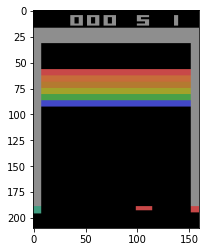

In [3]:
state = env.reset()

print(state.shape)
plt.imshow(state)
plt.show()

In [4]:
class NoopResetEnv(Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        super().__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

In [5]:
class MaxAndSkipEnv(Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(self._obs_buffer, axis=0)

        return max_frame, total_reward, done, info

In [6]:
class EpisodicLifeEnv(Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super().__init__(env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

In [7]:
class FireResetEnv(Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

In [8]:
class WarpFrame(ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

(84, 84, 1)


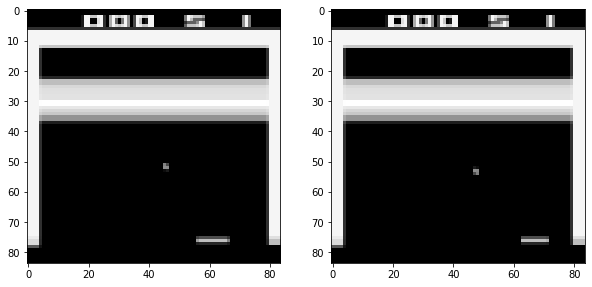

In [9]:
def make_atari(name):
    env = gym.make(ENV_NAME)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    return env


env = make_atari(ENV_NAME)
state = env.reset()
print(state.shape)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(state[:, :, 0], cmap='gray')

state, _, _, _ = env.step(env.action_space.sample())

plt.subplot(1, 2, 2)
plt.imshow(state[:, :, 0], cmap='gray')

plt.show()

In [10]:
test_env = make_atari(ENV_NAME)

In [11]:
class ReplayBuffer(object):
    """
    states, action, reward, done will be store as
    s0, s1, s2, s3, ......, sn-1, sn
    0,  a1, a2, a3, ......, an-1, an
    0,  r1, r2, r3, ......, rn-1, rn
    F,   F,  F,  F, ......,    F, True
    
    where sn is the end state
    """
    def __init__(self, buffer_size, history_size, state_shape=[], dtype=np.uint8):
        self.buffer_size = buffer_size
        self.history_size = history_size
        self.current_index = 0
        self.current_size = 0
        self.end = True
        self.memory = np.zeros(shape=[buffer_size] + state_shape, dtype=dtype)
        self.action = np.zeros(shape=[buffer_size], dtype=np.int32)
        self.reward = np.zeros(shape=[buffer_size], dtype=np.float32)
        self.done = np.zeros(shape=[buffer_size], dtype=np.bool)
        
    def add_init_state(self, state):
        self.add(state, 0, 0, False)
    
    def add(self, state, action, reward, done):
        idx = self.current_index
        self.memory[idx, ...] = state[:, :, 0]
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx] = done
        self.current_index = (self.current_index + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)
        
    def get_slice(self, index):
        """
        done[index-1] should never be True
        """
        if index < self.history_size:
            states = np.concatenate([self.memory[index-self.history_size:, ...],
                                     self.memory[:index+1, ...]], axis=0)
            action = self.action[index]
            reward = self.reward[index]
            done = self.done[index]
        else:
            states = self.memory[index-self.history_size:index+1, ...]
            action = self.action[index]
            reward = self.reward[index]
            done = self.done[index]
        
        states = np.copy(states)
        
        # fill with first frame when found last episode
        prev = False
        start_frame = self.memory[index-1]
        for i in range(index-2, index-self.history_size-1, -1):
            prev = prev or self.done[i]
            if prev:
                states[i - index + self.history_size] = start_frame
            else:
                start_frame = self.memory[i]
        
        states = np.transpose(states, [1, 2, 0])
        return states, action, reward, done
            
    def get_step(self, index):
        states, action, reward, done = self.get_slice(index)
        next_states = states[:, :, 1:]
        states = states[:, :, :-1]
        return states, action, reward, done, next_states
    
    def should_sample(self, index):
        return (not self.done[index-1]) and index >= self.history_size
    
    def sample_index(self):
        index = np.random.randint(0, self.current_size-1)
        while not self.should_sample(index):
            index = np.random.randint(0, self.current_size-1)
        return index
    
    def sample(self, pos_prob):
        index = self.sample_index()
        return self.get_step(index)
    
    def next_batch(self, batch_size, pos_prob=0.2):
        assert self.current_size > 1
        
        batch_states = []
        batch_next_states = []
        batch_action = []
        batch_reward = []
        batch_done = []
        for _ in range(batch_size):
            states, action, reward, done, next_states = self.sample(pos_prob)
            batch_states.append(states)
            batch_action.append(action)
            batch_reward.append(reward)
            batch_done.append(done)
            batch_next_states.append(next_states)
        batch_states = np.array(batch_states)
        batch_action = np.array(batch_action)
        batch_reward = np.array(batch_reward)
        batch_done = np.array(batch_done)
        batch_next_states = np.array(batch_next_states)
        return batch_states, batch_action, batch_reward, batch_done, batch_next_states


HISTORY_SIZE = 4
INPUT_SIZE = [84, 84]
replay_buffer = ReplayBuffer(300, HISTORY_SIZE, state_shape=INPUT_SIZE)

env = make_atari(ENV_NAME)
for episode in range(2):
    step = 0
    state = env.reset()
    replay_buffer.add_init_state(state)
    while True:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(next_state, action, reward, done)
        state = next_state
        step += 1
        if done:
            break
    print('total steps: ', step)


print(replay_buffer.done)
print(replay_buffer.action)
print(replay_buffer.reward)
print('current_size: ', replay_buffer.current_size)

total steps:  23
total steps:  67
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fals

In [13]:
assert not replay_buffer.should_sample(0)
assert not replay_buffer.should_sample(1)
assert not replay_buffer.should_sample(2)
assert not replay_buffer.should_sample(3)
assert replay_buffer.should_sample(4)

assert not replay_buffer.should_sample(24)
assert replay_buffer.should_sample(60)

assert not replay_buffer.should_sample(92)

step:  0
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  1
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  2
states:  (84, 84, 4) (84, 84, 4)
action:  1
reward:  0.0
done:  False
step:  3
states:  (84, 84, 4) (84, 84, 4)
action:  1
reward:  0.0
done:  False


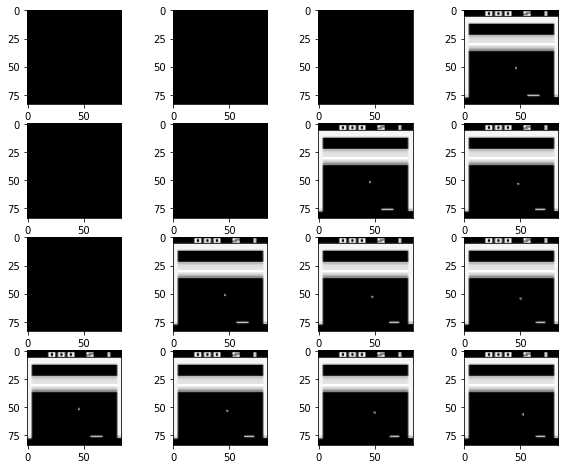

In [14]:
def show_replay_buffer(offset):
    plt.figure(figsize=(10, 8))
    for i in range(4):
        state, action, reward, done, next_state = replay_buffer.get_step(offset+i)
        print('step: ', offset+i)
        print('states: ', state.shape, next_state.shape)
        print('action: ', action)
        print('reward: ', reward)
        print('done: ', done)

        # for k in range(4-i):
        #     assert np.all(state[:, :, 0] == state[:, :, k])

        for j in range(HISTORY_SIZE):
            plt.subplot(HISTORY_SIZE, HISTORY_SIZE, i * HISTORY_SIZE + j + 1)
            plt.imshow(next_state[:, :, j], cmap='gray')

    plt.show()


show_replay_buffer(0)

step:  4
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  5
states:  (84, 84, 4) (84, 84, 4)
action:  2
reward:  0.0
done:  False
step:  6
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  7
states:  (84, 84, 4) (84, 84, 4)
action:  3
reward:  0.0
done:  False


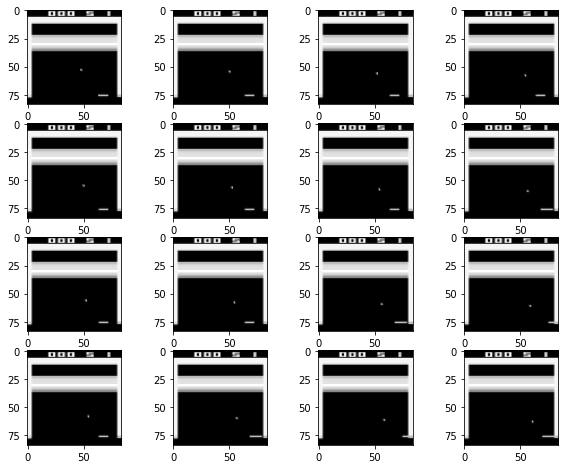

In [15]:
show_replay_buffer(4)

step:  60
states:  (84, 84, 4) (84, 84, 4)
action:  3
reward:  1.0
done:  False
step:  61
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  62
states:  (84, 84, 4) (84, 84, 4)
action:  3
reward:  0.0
done:  False
step:  63
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False


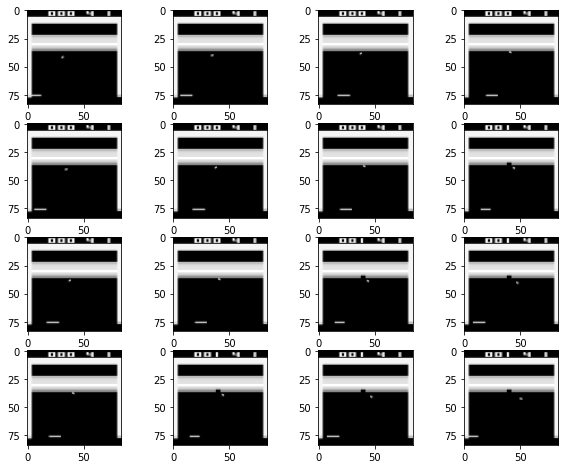

In [16]:
show_replay_buffer(60)

step:  91
states:  (84, 84, 4) (84, 84, 4)
action:  1
reward:  0.0
done:  True
step:  92
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  93
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False
step:  94
states:  (84, 84, 4) (84, 84, 4)
action:  0
reward:  0.0
done:  False


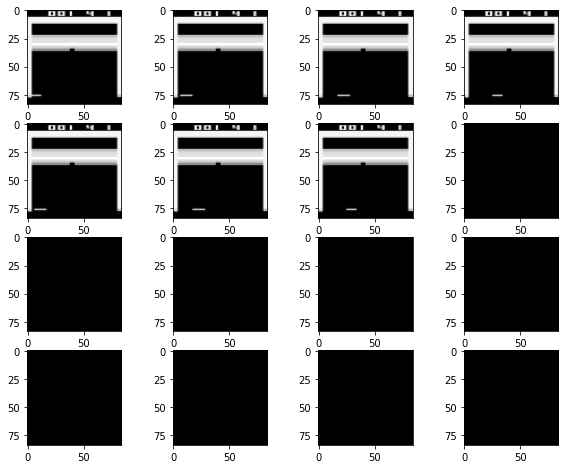

In [19]:
show_replay_buffer(91)

In [20]:
def collect_episode(policy):
    state = env.reset()
    replay_buffer.add_init_state(state)
    while True:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(next_state, action, reward, done)
        if done:
            break

def random_policy(_):
    return env.action_space.sample()


def initial_collect(init_size):
    env = make_atari(ENV_NAME)
    while replay_buffer.current_size < init_size:
        collect_episode(random_policy)
        print('\rcurrent size: ', replay_buffer.current_size, end='')
    print()


REPLAY_BUFFER_SIZE = 1000000
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE, HISTORY_SIZE,
                             state_shape=[INPUT_SIZE[0], INPUT_SIZE[1]])

REPLAY_BUFFER_INIT_SIZE = 60000
initial_collect(REPLAY_BUFFER_INIT_SIZE)

assert np.sum(replay_buffer.reward) > 0

current size:  60017


In [21]:
def build_model(num_actions):
    return keras.Sequential([
        keras.layers.Conv2D(32, 8, 4, padding='same', activation='relu',
                            kernel_initializer=keras.initializers.VarianceScaling(2.0),
                            input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], HISTORY_SIZE]),
        keras.layers.Conv2D(64, 4, 2, padding='same',
                            kernel_initializer=keras.initializers.VarianceScaling(2.0),
                            activation='relu'),
        keras.layers.Conv2D(64, 3, 1, padding='same',
                            kernel_initializer=keras.initializers.VarianceScaling(2.0),
                            activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(512, kernel_initializer=keras.initializers.VarianceScaling(2.0),
                           activation='relu'),
        keras.layers.Dense(num_actions)
    ])


NUM_ACTIONS = env.action_space.n
keras.backend.clear_session()
Q = build_model(NUM_ACTIONS)
Q.summary()

target_Q = build_model(NUM_ACTIONS)
# optimizer = keras.optimizers.RMSprop(2.5e-4, rho=0.95, momentum=0.95, epsilon=0.01)
# optimizer = keras.optimizers.Adam(1.26e-5, decay=0.0)
# optimizer = keras.optimizers.Adam(1e-5)
optimizer = keras.optimizers.Adam(6.25e-5, eps=1e-4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3965440   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 4,045,476
Trainable params: 4,045,476
Non-trainable params: 0
______________________________________________

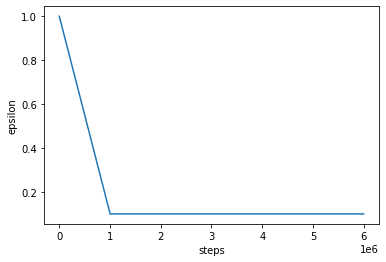

In [22]:
class EpsilonGreedyPolicy(object):
    def __init__(self, decay_duration, min_eps=0.1):
        self.decay_duration = decay_duration
        self.min_eps = min_eps
        self.eps = self.compute_eps(0)
        
    def compute_eps(self, step):
        return (1.0 - self.min_eps) * np.maximum(self.decay_duration - step, 0) / self.decay_duration + self.min_eps

    def update(self, step):
        self.eps = self.compute_eps(step)
    
    def __call__(self, state):
        if np.random.uniform() < self.eps:
            return env.action_space.sample()
        else:
            s = tf.cast(state[tf.newaxis], tf.float32) / 255.0
            q = Q(s, training=False)
            action = tf.argmax(q[0]).numpy()
            return action


epsilon_greedy = EpsilonGreedyPolicy(1000000)
steps = np.arange(6000000)
eps = epsilon_greedy.compute_eps(steps)

plt.plot(steps, eps)
plt.xlabel('steps')
plt.ylabel('epsilon')
plt.show()

In [23]:
def eval_reward(policy, num_episodes=10):
    R = []
    for episode in range(num_episodes):
        state = test_env.reset()
        buffer = deque(maxlen=HISTORY_SIZE)
        for _ in range(HISTORY_SIZE):
            buffer.append(state[:, :, 0])
        # buffer.append(state[:, :, 0])
        
        total_reward = 0
        while True:
            state_buf = np.stack(buffer, axis=-1)
            action = policy(state_buf)
            next_state, reward, done, _ = test_env.step(action)
            total_reward += reward
            state = next_state
            buffer.append(state[:, :, 0])
            if done:
                break
        R.append(total_reward)
    return np.mean(R), np.min(R), np.max(R)


R = eval_reward(epsilon_greedy)
print(R)

(0.0, 0.0, 0.0)


In [24]:
GAMMA = 0.99

@tf.function
def train_step(states, actions, rewards, done, next_states):
    with tf.GradientTape() as tape:
        states = tf.cast(states, tf.float32) / 255.0
        next_states = tf.cast(next_states, tf.float32) / 255.0
        r = tf.clip_by_value(rewards, -1.0, 1.0)
        not_done = tf.cast(tf.logical_not(done), tf.float32)
        q_primes = target_Q(next_states, training=False)
        
        max_a = tf.one_hot(tf.argmax(Q(next_states), axis=1), env.action_space.n)
        max_a = tf.stop_gradient(max_a)
        target_q = tf.reduce_sum(q_primes * max_a, axis=1)
        # y = r + GAMMA * not_done * tf.reduce_max(q_primes, axis=1)
        y = r + GAMMA * not_done * target_q
        
        q_values = Q(states)
        mask = tf.one_hot(actions, env.action_space.n)
        x = tf.reduce_sum(mask * q_values, axis=1)
        huber = keras.losses.Huber()(y, x)
        
    grad = tape.gradient(huber, Q.trainable_variables)
    optimizer.apply_gradients(zip(grad, Q.trainable_variables))
    return huber, tf.reduce_max(q_values)



BATCH_SIZE = 32
states, actions, rewards, done, next_states = replay_buffer.next_batch(BATCH_SIZE)
loss, max_q, = train_step(states, actions, rewards, done, next_states)
print('loss: ', loss)
print('max q: ', max_q)

loss:  tf.Tensor(0.3825183, shape=(), dtype=float32)
max q:  tf.Tensor(0.8447434, shape=(), dtype=float32)


In [25]:
def learning_rate_schedule(step):
    if step < 1000000:
        return 2.5e-4
    elif step <= 2000000:
        return 1e-4
    return 5e-5


def run(starting_step=0, max_steps=30000000, update_interval=10000, train_interval=4):
    checkpoint = tf.train.Checkpoint()
    checkpoint_path = '../checkpoint/atari/%s.checkpoint' % (ENV_NAME)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=3)
    
    step = starting_step
    while step < max_steps:
        # begin episode
        state = env.reset()
        replay_buffer.add_init_state(state)
        # prepare state buffer for inference
        # because the model needs HISTORY_SIZE=4 states to stack up
        buffer = deque(maxlen=HISTORY_SIZE)
        for _ in range(HISTORY_SIZE):
            buffer.append(state[:, :, 0])
        # buffer.append(state[:, :, 0])
        
        # run this episode
        losses = []
        max_qs = []
        while True:
            epsilon_greedy.update(step)
            state_buf = np.stack(np.array(buffer), axis=-1)
            # execute policy
            action = epsilon_greedy(state_buf)
            next_state, reward, done, _ = env.step(action)
            # collect data
            replay_buffer.add(next_state, action, reward, done)
            
            # training section
            # update weights
            if step % update_interval == 0:
                target_Q.set_weights(Q.get_weights())
            
            if step % train_interval == 0:
                states, actions, rewards, dones, next_states = replay_buffer.next_batch(BATCH_SIZE)
                loss, max_q = train_step(states, actions, rewards, dones, next_states)
                losses.append(loss.numpy())
                max_qs.append(max_q.numpy())
                print('\r%d. loss: %f, max Q: %f' % (step, np.mean(losses), np.mean(max_qs)), end='')
            
            if step % update_interval == 0 and step > 0:
                losses = []
                max_qs = []
                R = eval_reward(epsilon_greedy)
                start_time = time()
                # optimizer.learning_rate = learning_rate_schedule(step)
                print()
                print('mean: ', R[0], 'min: ', R[1], 'max: ', R[2])
                # print('rewards: ', R, ' --- new learning rate: ', optimizer.learning_rate.numpy())

            if step % (update_interval * 50) == 0 and step > 0:
                print('saving model...')
                manager.save()
            # end training section
            
            # continue next step
            step += 1
            state = next_state
            buffer.append(state[:, :, 0])
            if done:
                break


run()

10000. loss: 0.006425, max Q: 0.420951
mean:  0.2 min:  0.0 max:  1.0
20000. loss: 0.001358, max Q: 0.399414
mean:  0.3 min:  0.0 max:  1.0
30000. loss: 0.008123, max Q: 0.361654
mean:  0.0 min:  0.0 max:  0.0
40000. loss: 0.004955, max Q: 0.393088
mean:  0.4 min:  0.0 max:  1.0
50000. loss: 0.002004, max Q: 0.394725
mean:  0.2 min:  0.0 max:  2.0
60000. loss: 0.006681, max Q: 0.456563
mean:  0.6 min:  0.0 max:  2.0
70000. loss: 0.005686, max Q: 0.669317
mean:  0.5 min:  0.0 max:  1.0
80000. loss: 0.004193, max Q: 0.620271
mean:  0.1 min:  0.0 max:  1.0
90000. loss: 0.001754, max Q: 0.564563
mean:  0.3 min:  0.0 max:  2.0
100000. loss: 0.003091, max Q: 0.717429
mean:  0.3 min:  0.0 max:  2.0
110000. loss: 0.005654, max Q: 0.791891
mean:  0.1 min:  0.0 max:  1.0
120000. loss: 0.003798, max Q: 1.002858
mean:  0.0 min:  0.0 max:  0.0
130000. loss: 0.003957, max Q: 1.037221
mean:  0.3 min:  0.0 max:  3.0
140000. loss: 0.003178, max Q: 0.694460
mean:  0.0 min:  0.0 max:  0.0
150000. loss: 0

1160000. loss: 0.009728, max Q: 2.300052
mean:  2.4 min:  1.0 max:  6.0
1170000. loss: 0.005662, max Q: 2.323176
mean:  3.1 min:  0.0 max:  6.0
1180000. loss: 0.011446, max Q: 2.333953
mean:  2.9 min:  0.0 max:  7.0
1190000. loss: 0.007908, max Q: 2.301860
mean:  2.8 min:  1.0 max:  8.0
1200000. loss: 0.009505, max Q: 2.296394
mean:  2.8 min:  1.0 max:  4.0
1210000. loss: 0.011142, max Q: 2.347117
mean:  2.9 min:  1.0 max:  7.0
1220000. loss: 0.012083, max Q: 2.265424
mean:  2.8 min:  1.0 max:  7.0
1230000. loss: 0.008875, max Q: 2.353999
mean:  2.3 min:  1.0 max:  7.0
1240000. loss: 0.007512, max Q: 2.536724
mean:  3.0 min:  0.0 max:  7.0
1250000. loss: 0.008920, max Q: 2.415918
mean:  3.4 min:  0.0 max:  10.0
1260000. loss: 0.011376, max Q: 2.432762
mean:  2.2 min:  1.0 max:  5.0
1270000. loss: 0.008674, max Q: 2.436963
mean:  2.5 min:  0.0 max:  7.0
1280000. loss: 0.011202, max Q: 2.451198
mean:  3.7 min:  1.0 max:  10.0
1290000. loss: 0.008089, max Q: 2.418161
mean:  4.6 min:  1.0 

2280000. loss: 0.011397, max Q: 3.2761942
mean:  4.4 min:  2.0 max:  9.0
2290000. loss: 0.011061, max Q: 3.2378032
mean:  4.3 min:  1.0 max:  9.0
2300000. loss: 0.013795, max Q: 2.7459859
mean:  5.8 min:  1.0 max:  16.0
2310000. loss: 0.012495, max Q: 3.1923946
mean:  10.7 min:  2.0 max:  20.0
2320000. loss: 0.007107, max Q: 2.7471159
mean:  6.1 min:  1.0 max:  16.0
2330000. loss: 0.031455, max Q: 4.6645217
mean:  7.4 min:  1.0 max:  18.0
2340000. loss: 0.010854, max Q: 2.8844839
mean:  5.5 min:  1.0 max:  12.0
2350000. loss: 0.012948, max Q: 2.9907325
mean:  3.6 min:  0.0 max:  9.0
2360000. loss: 0.009780, max Q: 2.8125960
mean:  7.0 min:  0.0 max:  20.0
2370000. loss: 0.015036, max Q: 2.8634850
mean:  4.3 min:  1.0 max:  11.0
2380000. loss: 0.018093, max Q: 3.9604319
mean:  27.4 min:  0.0 max:  218.0
2390000. loss: 0.012306, max Q: 2.8811462
mean:  4.0 min:  1.0 max:  12.0
2400000. loss: 0.016041, max Q: 2.8396761
mean:  5.1 min:  1.0 max:  17.0
2410000. loss: 0.010794, max Q: 2.9114

3380000. loss: 0.013504, max Q: 3.7633196
mean:  3.8 min:  1.0 max:  7.0
3390000. loss: 0.016936, max Q: 6.9322251
mean:  29.5 min:  0.0 max:  218.0
3400000. loss: 0.020290, max Q: 4.4400738
mean:  13.0 min:  5.0 max:  26.0
3410000. loss: 0.014100, max Q: 3.4159040
mean:  13.3 min:  4.0 max:  40.0
3420000. loss: 0.014194, max Q: 4.3709719
mean:  8.3 min:  0.0 max:  26.0
3430000. loss: 0.013045, max Q: 5.7997765
mean:  11.1 min:  6.0 max:  19.0
3440000. loss: 0.008339, max Q: 3.0461492
mean:  9.3 min:  4.0 max:  14.0
3450000. loss: 0.015634, max Q: 3.6275818
mean:  9.1 min:  2.0 max:  21.0
3460000. loss: 0.017429, max Q: 3.7368850
mean:  9.6 min:  5.0 max:  22.0
3470000. loss: 0.016204, max Q: 8.1367659
mean:  6.2 min:  1.0 max:  12.0
3480000. loss: 0.025222, max Q: 5.3580432
mean:  7.9 min:  0.0 max:  24.0
3490000. loss: 0.016657, max Q: 3.8906215
mean:  8.1 min:  1.0 max:  20.0
3500000. loss: 0.016004, max Q: 3.2092378
mean:  5.6 min:  1.0 max:  19.0
saving model...
3510000. loss: 0.0

4470000. loss: 0.025625, max Q: 6.5204171
mean:  10.1 min:  1.0 max:  24.0
4480000. loss: 0.016348, max Q: 6.1460299
mean:  10.5 min:  2.0 max:  25.0
4490000. loss: 0.017409, max Q: 5.3055090
mean:  10.4 min:  1.0 max:  35.0
4500000. loss: 0.018337, max Q: 6.2960544
mean:  20.4 min:  0.0 max:  60.0
saving model...
4510000. loss: 0.020875, max Q: 6.2346733
mean:  28.4 min:  0.0 max:  218.0
4520000. loss: 0.016816, max Q: 7.5920440
mean:  7.4 min:  0.0 max:  16.0
4530000. loss: 0.024390, max Q: 6.1582914
mean:  9.8 min:  0.0 max:  23.0
4540000. loss: 0.019887, max Q: 6.4703556
mean:  12.0 min:  0.0 max:  42.0
4550000. loss: 0.019843, max Q: 5.2050996
mean:  7.8 min:  1.0 max:  27.0
4560000. loss: 0.025760, max Q: 6.9551378
mean:  9.9 min:  1.0 max:  26.0
4570000. loss: 0.021551, max Q: 5.9109154
mean:  10.2 min:  3.0 max:  26.0
4580000. loss: 0.015288, max Q: 6.1320675
mean:  6.9 min:  3.0 max:  10.0
4590000. loss: 0.016499, max Q: 4.7275167
mean:  13.8 min:  7.0 max:  24.0
4600000. loss

5560000. loss: 0.018355, max Q: 7.8652810
mean:  12.7 min:  5.0 max:  22.0
5570000. loss: 0.013510, max Q: 5.3519665
mean:  28.6 min:  0.0 max:  224.0
5580000. loss: 0.016124, max Q: 8.8400647
mean:  9.8 min:  1.0 max:  19.0
5590000. loss: 0.015976, max Q: 7.2769743
mean:  57.8 min:  0.0 max:  364.0
5600000. loss: 0.025305, max Q: 7.6661151
mean:  29.4 min:  6.0 max:  176.0
5610000. loss: 0.017847, max Q: 7.1122356
mean:  12.4 min:  5.0 max:  36.0
5620000. loss: 0.019545, max Q: 7.3181034
mean:  13.8 min:  1.0 max:  31.0
5630000. loss: 0.017030, max Q: 7.7021321
mean:  13.9 min:  4.0 max:  42.0
5640000. loss: 0.018621, max Q: 7.5496527
mean:  9.8 min:  1.0 max:  22.0
5650000. loss: 0.013487, max Q: 7.7845846
mean:  8.8 min:  1.0 max:  18.0
5660000. loss: 0.019636, max Q: 7.9300188
mean:  11.3 min:  4.0 max:  22.0
5670000. loss: 0.020797, max Q: 8.0190090
mean:  13.2 min:  2.0 max:  51.0
5680000. loss: 0.019758, max Q: 8.0068394
mean:  7.4 min:  0.0 max:  16.0
5690000. loss: 0.012912, m

6650000. loss: 0.021682, max Q: 7.4560550
mean:  12.6 min:  2.0 max:  27.0
6660000. loss: 0.023553, max Q: 9.8254671
mean:  8.5 min:  0.0 max:  18.0
6670000. loss: 0.020788, max Q: 7.7549799
mean:  30.2 min:  1.0 max:  227.0
6680000. loss: 0.017842, max Q: 7.5711463
mean:  11.1 min:  2.0 max:  24.0
6690000. loss: 0.011012, max Q: 7.5243701
mean:  36.4 min:  0.0 max:  218.0
6700000. loss: 0.013483, max Q: 7.5143844
mean:  15.8 min:  4.0 max:  39.0
6710000. loss: 0.022259, max Q: 8.2246486
mean:  12.1 min:  2.0 max:  34.0
6720000. loss: 0.012910, max Q: 5.8931578
mean:  25.8 min:  4.0 max:  138.0
6730000. loss: 0.019434, max Q: 7.0520597
mean:  15.8 min:  2.0 max:  48.0
6740000. loss: 0.015750, max Q: 8.5030059
mean:  6.8 min:  0.0 max:  17.0
6750000. loss: 0.018199, max Q: 8.5614420
mean:  44.9 min:  9.0 max:  226.0
6760000. loss: 0.016415, max Q: 8.2971517
mean:  8.7 min:  0.0 max:  20.0
6770000. loss: 0.016988, max Q: 8.2621746
mean:  10.3 min:  3.0 max:  21.0
6780000. loss: 0.021505,

7740000. loss: 0.022144, max Q: 10.192524
mean:  11.6 min:  1.0 max:  29.0
7750000. loss: 0.026661, max Q: 7.0416595
mean:  12.0 min:  1.0 max:  70.0
7760000. loss: 0.066942, max Q: 9.2420493
mean:  25.1 min:  0.0 max:  134.0
7770000. loss: 0.022781, max Q: 11.114398
mean:  11.5 min:  4.0 max:  24.0
7780000. loss: 0.025676, max Q: 10.396029
mean:  8.1 min:  3.0 max:  22.0
7790000. loss: 0.029398, max Q: 10.225795
mean:  14.6 min:  6.0 max:  37.0
7800000. loss: 0.030123, max Q: 9.9200552
mean:  8.9 min:  1.0 max:  25.0
7810000. loss: 0.031217, max Q: 10.401725
mean:  14.3 min:  6.0 max:  44.0
7820000. loss: 0.019854, max Q: 12.114787
mean:  11.7 min:  2.0 max:  33.0
7830000. loss: 0.038225, max Q: 10.769086
mean:  13.5 min:  4.0 max:  24.0
7840000. loss: 0.029197, max Q: 10.313622
mean:  29.0 min:  3.0 max:  176.0
7850000. loss: 0.028664, max Q: 10.699044
mean:  14.1 min:  0.0 max:  59.0
7860000. loss: 0.016799, max Q: 8.3702749
mean:  14.2 min:  3.0 max:  35.0
7870000. loss: 0.019038, 

8820000. loss: 0.032628, max Q: 10.374446
mean:  19.8 min:  2.0 max:  38.0
8830000. loss: 0.024687, max Q: 9.8570295
mean:  13.3 min:  0.0 max:  45.0
8840000. loss: 0.042079, max Q: 10.953857
mean:  19.0 min:  2.0 max:  40.0
8850000. loss: 0.029600, max Q: 10.591802
mean:  31.6 min:  4.0 max:  156.0
8860000. loss: 0.032561, max Q: 9.1481695
mean:  12.7 min:  0.0 max:  35.0
8870000. loss: 0.031464, max Q: 11.077520
mean:  33.8 min:  0.0 max:  176.0
8880000. loss: 0.023209, max Q: 12.536031
mean:  15.2 min:  2.0 max:  38.0
8890000. loss: 0.031511, max Q: 10.875688
mean:  14.8 min:  0.0 max:  37.0
8900000. loss: 0.027947, max Q: 10.986503
mean:  40.3 min:  0.0 max:  169.0
8910000. loss: 0.035855, max Q: 9.3172176
mean:  22.9 min:  2.0 max:  93.0
8920000. loss: 0.031419, max Q: 11.570424
mean:  39.9 min:  0.0 max:  267.0
8930000. loss: 0.035308, max Q: 9.5192053
mean:  38.3 min:  0.0 max:  281.0
8940000. loss: 0.020436, max Q: 11.492794
mean:  8.0 min:  4.0 max:  31.0
8950000. loss: 0.0282

9900000. loss: 0.034416, max Q: 12.907382
mean:  26.3 min:  7.0 max:  68.0
9910000. loss: 0.057069, max Q: 13.536281
mean:  40.8 min:  1.0 max:  188.0
9920000. loss: 0.039787, max Q: 12.299810
mean:  22.7 min:  0.0 max:  67.0
9930000. loss: 0.032992, max Q: 12.154763
mean:  40.1 min:  2.0 max:  305.0
9940000. loss: 0.034995, max Q: 12.877549
mean:  16.4 min:  0.0 max:  46.0
9950000. loss: 0.034039, max Q: 12.605266
mean:  44.1 min:  0.0 max:  291.0
9960000. loss: 0.025744, max Q: 11.164779
mean:  50.2 min:  1.0 max:  291.0
9970000. loss: 0.038207, max Q: 13.583044
mean:  39.4 min:  0.0 max:  257.0
9980000. loss: 0.033384, max Q: 13.044432
mean:  13.2 min:  2.0 max:  30.0
9990000. loss: 0.032826, max Q: 12.540426
mean:  49.2 min:  0.0 max:  344.0
10000000. loss: 0.042305, max Q: 12.443206
mean:  19.5 min:  8.0 max:  34.0
saving model...
10010000. loss: 0.032558, max Q: 11.538965
mean:  12.5 min:  0.0 max:  51.0
10020000. loss: 0.040232, max Q: 13.849242
mean:  27.8 min:  4.0 max:  137.0

10970000. loss: 0.045251, max Q: 13.190365
mean:  12.1 min:  4.0 max:  42.0
10980000. loss: 0.030563, max Q: 14.164838
mean:  22.6 min:  4.0 max:  56.0
10990000. loss: 0.056317, max Q: 12.153818
mean:  33.6 min:  1.0 max:  139.0
11000000. loss: 0.036111, max Q: 13.068889
mean:  31.0 min:  1.0 max:  203.0
saving model...
11010000. loss: 0.045553, max Q: 13.147601
mean:  31.0 min:  5.0 max:  74.0
11020000. loss: 0.036640, max Q: 13.777939
mean:  28.8 min:  1.0 max:  146.0
11030000. loss: 0.037957, max Q: 12.562149
mean:  61.1 min:  4.0 max:  304.0
11040000. loss: 0.042694, max Q: 12.622084
mean:  20.4 min:  2.0 max:  57.0
11050000. loss: 0.039293, max Q: 12.712246
mean:  17.4 min:  2.0 max:  43.0
11060000. loss: 0.033518, max Q: 12.000084
mean:  33.9 min:  0.0 max:  170.0
11070000. loss: 0.043528, max Q: 13.560849
mean:  51.8 min:  1.0 max:  208.0
11080000. loss: 0.032252, max Q: 11.850398
mean:  39.4 min:  0.0 max:  148.0
11090000. loss: 0.047136, max Q: 12.667969
mean:  37.3 min:  4.0 

12030000. loss: 0.022382, max Q: 11.849096
mean:  50.1 min:  0.0 max:  258.0
12040000. loss: 0.038969, max Q: 13.436806
mean:  23.7 min:  0.0 max:  94.0
12050000. loss: 0.045352, max Q: 13.132162
mean:  58.1 min:  2.0 max:  320.0
12060000. loss: 0.029659, max Q: 14.592601
mean:  11.8 min:  1.0 max:  34.0
12070000. loss: 0.045437, max Q: 13.345383
mean:  39.2 min:  3.0 max:  135.0
12080000. loss: 0.010349, max Q: 17.309383
mean:  41.0 min:  10.0 max:  130.0
12090000. loss: 0.042527, max Q: 14.579020
mean:  31.7 min:  4.0 max:  117.0
12100000. loss: 0.038692, max Q: 13.167053
mean:  22.4 min:  1.0 max:  141.0
12110000. loss: 0.031585, max Q: 13.354774
mean:  20.9 min:  0.0 max:  105.0
12120000. loss: 0.042983, max Q: 13.561755
mean:  44.9 min:  0.0 max:  100.0
12130000. loss: 0.036239, max Q: 13.125407
mean:  41.6 min:  2.0 max:  259.0
12140000. loss: 0.044616, max Q: 13.193460
mean:  36.2 min:  1.0 max:  189.0
12150000. loss: 0.045999, max Q: 13.627436
mean:  58.1 min:  2.0 max:  207.0


13090000. loss: 0.040011, max Q: 12.682373
mean:  53.5 min:  1.0 max:  327.0
13100000. loss: 0.043164, max Q: 13.257996
mean:  61.0 min:  3.0 max:  261.0
13110000. loss: 0.050066, max Q: 12.923727
mean:  20.9 min:  1.0 max:  59.0
13120000. loss: 0.047817, max Q: 13.437128
mean:  23.3 min:  0.0 max:  55.0
13130000. loss: 0.041890, max Q: 12.891867
mean:  57.2 min:  11.0 max:  300.0
13140000. loss: 0.055710, max Q: 14.225552
mean:  46.0 min:  0.0 max:  365.0
13150000. loss: 0.061813, max Q: 13.869852
mean:  42.9 min:  1.0 max:  273.0
13160000. loss: 0.046529, max Q: 15.005476
mean:  24.5 min:  0.0 max:  87.0
13170000. loss: 0.033451, max Q: 12.934519
mean:  63.2 min:  4.0 max:  288.0
13180000. loss: 0.027278, max Q: 13.215235
mean:  61.8 min:  11.0 max:  127.0
13190000. loss: 0.023694, max Q: 12.684199
mean:  36.7 min:  3.0 max:  202.0
13200000. loss: 0.031767, max Q: 12.913754
mean:  37.6 min:  0.0 max:  278.0
13210000. loss: 0.036519, max Q: 13.279460
mean:  59.1 min:  7.0 max:  216.0


14150000. loss: 0.042325, max Q: 12.858453
mean:  51.6 min:  1.0 max:  289.0
14160000. loss: 0.039935, max Q: 14.689020
mean:  28.1 min:  1.0 max:  191.0
14170000. loss: 0.037240, max Q: 14.739634
mean:  40.4 min:  11.0 max:  73.0
14180000. loss: 0.047741, max Q: 13.569803
mean:  44.0 min:  20.0 max:  163.0
14190000. loss: 0.037407, max Q: 13.940787
mean:  13.9 min:  1.0 max:  65.0
14200000. loss: 0.029843, max Q: 12.013366
mean:  64.1 min:  0.0 max:  271.0
14210000. loss: 0.036853, max Q: 12.841020
mean:  44.7 min:  7.0 max:  139.0
14220000. loss: 0.038164, max Q: 13.590667
mean:  75.9 min:  1.0 max:  278.0
14230000. loss: 0.040792, max Q: 13.526496
mean:  27.5 min:  1.0 max:  127.0
14240000. loss: 0.036357, max Q: 13.712632
mean:  71.1 min:  4.0 max:  317.0
14250000. loss: 0.044646, max Q: 14.100924
mean:  12.6 min:  1.0 max:  33.0
14260000. loss: 0.069905, max Q: 13.036063
mean:  17.9 min:  1.0 max:  51.0
14270000. loss: 0.034417, max Q: 12.829211
mean:  68.8 min:  6.0 max:  256.0
1

15210000. loss: 0.051306, max Q: 11.324735
mean:  13.5 min:  1.0 max:  44.0
15220000. loss: 0.031993, max Q: 13.631485
mean:  37.5 min:  4.0 max:  87.0
15230000. loss: 0.052229, max Q: 13.086645
mean:  43.1 min:  7.0 max:  198.0
15240000. loss: 0.034454, max Q: 13.265803
mean:  16.3 min:  1.0 max:  41.0
15250000. loss: 0.032151, max Q: 14.507311
mean:  56.8 min:  4.0 max:  227.0
15260000. loss: 0.035414, max Q: 14.162268
mean:  34.7 min:  3.0 max:  130.0
15270000. loss: 0.043846, max Q: 13.594104
mean:  69.5 min:  13.0 max:  255.0
15280000. loss: 0.036541, max Q: 14.003058
mean:  11.1 min:  1.0 max:  25.0
15290000. loss: 0.034666, max Q: 13.490975
mean:  75.5 min:  0.0 max:  388.0
15300000. loss: 0.039326, max Q: 14.072711
mean:  19.5 min:  1.0 max:  71.0
15310000. loss: 0.044596, max Q: 13.619416
mean:  74.7 min:  6.0 max:  286.0
15320000. loss: 0.044684, max Q: 13.704678
mean:  43.1 min:  1.0 max:  104.0
15330000. loss: 0.051570, max Q: 14.061501
mean:  39.7 min:  7.0 max:  177.0
153

16270000. loss: 0.026743, max Q: 14.833592
mean:  76.4 min:  5.0 max:  338.0
16280000. loss: 0.036560, max Q: 13.593839
mean:  43.4 min:  1.0 max:  197.0
16290000. loss: 0.036815, max Q: 14.462046
mean:  55.2 min:  0.0 max:  211.0
16300000. loss: 0.039805, max Q: 13.197722
mean:  32.0 min:  2.0 max:  119.0
16310000. loss: 0.035794, max Q: 13.993461
mean:  70.1 min:  15.0 max:  248.0
16320000. loss: 0.033736, max Q: 14.087286
mean:  72.6 min:  1.0 max:  241.0
16330000. loss: 0.029424, max Q: 14.607209
mean:  70.9 min:  2.0 max:  343.0
16340000. loss: 0.035258, max Q: 14.204539
mean:  54.0 min:  1.0 max:  272.0
16350000. loss: 0.034305, max Q: 13.773462
mean:  50.8 min:  4.0 max:  182.0
16360000. loss: 0.035364, max Q: 13.852332
mean:  45.7 min:  2.0 max:  353.0
16370000. loss: 0.036128, max Q: 13.392364
mean:  48.9 min:  0.0 max:  198.0
16380000. loss: 0.038736, max Q: 13.867065
mean:  47.5 min:  0.0 max:  196.0
16390000. loss: 0.041103, max Q: 14.110548
mean:  71.4 min:  2.0 max:  272.

17330000. loss: 0.037999, max Q: 13.037238
mean:  38.7 min:  4.0 max:  147.0
17340000. loss: 0.035545, max Q: 13.433667
mean:  45.3 min:  2.0 max:  150.0
17350000. loss: 0.038399, max Q: 13.816921
mean:  74.2 min:  5.0 max:  279.0
17360000. loss: 0.040779, max Q: 13.879240
mean:  45.6 min:  0.0 max:  361.0
17370000. loss: 0.042123, max Q: 14.388935
mean:  20.2 min:  2.0 max:  45.0
17380000. loss: 0.037120, max Q: 13.687619
mean:  77.2 min:  2.0 max:  349.0
17390000. loss: 0.014287, max Q: 11.334177
mean:  58.4 min:  0.0 max:  189.0
17400000. loss: 0.024053, max Q: 13.989010
mean:  44.4 min:  4.0 max:  121.0
17410000. loss: 0.032927, max Q: 14.035334
mean:  35.5 min:  4.0 max:  86.0
17420000. loss: 0.035222, max Q: 13.587493
mean:  60.6 min:  7.0 max:  329.0
17430000. loss: 0.037460, max Q: 14.178921
mean:  37.5 min:  2.0 max:  149.0
17440000. loss: 0.040870, max Q: 14.143049
mean:  40.2 min:  0.0 max:  196.0
17450000. loss: 0.034780, max Q: 13.813059
mean:  15.3 min:  0.0 max:  48.0
17

18390000. loss: 0.026379, max Q: 11.915256
mean:  71.6 min:  6.0 max:  324.0
18400000. loss: 0.030405, max Q: 14.597553
mean:  78.5 min:  9.0 max:  374.0
18410000. loss: 0.036632, max Q: 14.691329
mean:  66.1 min:  2.0 max:  243.0
18420000. loss: 0.043089, max Q: 14.359844
mean:  36.8 min:  2.0 max:  144.0
18430000. loss: 0.042736, max Q: 14.342936
mean:  36.0 min:  1.0 max:  169.0
18440000. loss: 0.038558, max Q: 14.072858
mean:  50.4 min:  1.0 max:  249.0
18450000. loss: 0.024103, max Q: 13.956028
mean:  50.3 min:  3.0 max:  189.0
18460000. loss: 0.036983, max Q: 14.657377
mean:  40.1 min:  1.0 max:  306.0
18470000. loss: 0.040939, max Q: 14.443962
mean:  80.8 min:  0.0 max:  256.0
18480000. loss: 0.035417, max Q: 14.713659
mean:  72.6 min:  14.0 max:  172.0
18490000. loss: 0.038715, max Q: 14.361529
mean:  46.9 min:  0.0 max:  173.0
18500000. loss: 0.038122, max Q: 15.205950
mean:  75.4 min:  0.0 max:  249.0
saving model...
18510000. loss: 0.048995, max Q: 15.005436
mean:  15.7 min:

19450000. loss: 0.021491, max Q: 14.107623
mean:  53.5 min:  4.0 max:  206.0
19460000. loss: 0.037105, max Q: 14.043093
mean:  19.8 min:  0.0 max:  66.0
19470000. loss: 0.033186, max Q: 14.901009
mean:  23.1 min:  2.0 max:  68.0
19480000. loss: 0.037270, max Q: 14.634072
mean:  37.8 min:  0.0 max:  288.0
19490000. loss: 0.026011, max Q: 14.766657
mean:  19.4 min:  2.0 max:  96.0
19500000. loss: 0.041531, max Q: 13.744927
mean:  42.4 min:  0.0 max:  108.0
saving model...
19510000. loss: 0.033969, max Q: 14.214134
mean:  79.0 min:  11.0 max:  290.0
19520000. loss: 0.033871, max Q: 14.066465
mean:  51.0 min:  7.0 max:  144.0
19530000. loss: 0.032838, max Q: 14.085926
mean:  43.7 min:  4.0 max:  186.0
19540000. loss: 0.029304, max Q: 14.721244
mean:  49.6 min:  0.0 max:  114.0
19550000. loss: 0.017667, max Q: 13.322321
mean:  50.9 min:  2.0 max:  260.0
19560000. loss: 0.029561, max Q: 13.995704
mean:  70.1 min:  3.0 max:  185.0
19570000. loss: 0.034728, max Q: 15.506550
mean:  78.2 min:  0

20510000. loss: 0.032337, max Q: 13.411453
mean:  47.9 min:  0.0 max:  143.0
20520000. loss: 0.032245, max Q: 14.071175
mean:  78.9 min:  2.0 max:  358.0
20530000. loss: 0.030965, max Q: 14.673008
mean:  71.9 min:  0.0 max:  343.0
20540000. loss: 0.045163, max Q: 15.689455
mean:  63.8 min:  1.0 max:  302.0
20550000. loss: 0.026238, max Q: 13.702214
mean:  78.6 min:  1.0 max:  177.0
20560000. loss: 0.034254, max Q: 14.121497
mean:  7.9 min:  1.0 max:  23.0
20570000. loss: 0.030387, max Q: 13.139750
mean:  70.0 min:  0.0 max:  317.0
20580000. loss: 0.045509, max Q: 14.270569
mean:  43.4 min:  0.0 max:  267.0
20590000. loss: 0.037722, max Q: 14.008248
mean:  27.0 min:  0.0 max:  217.0
20600000. loss: 0.035588, max Q: 14.864049
mean:  25.1 min:  0.0 max:  102.0
20610000. loss: 0.043896, max Q: 14.273474
mean:  69.6 min:  1.0 max:  314.0
20620000. loss: 0.033631, max Q: 13.934115
mean:  46.6 min:  2.0 max:  345.0
20630000. loss: 0.034125, max Q: 13.798471
mean:  79.1 min:  0.0 max:  309.0
2

21570000. loss: 0.034488, max Q: 14.425525
mean:  76.5 min:  0.0 max:  319.0
21580000. loss: 0.033305, max Q: 14.301969
mean:  70.6 min:  6.0 max:  194.0
21590000. loss: 0.031154, max Q: 14.479609
mean:  10.7 min:  0.0 max:  28.0
21600000. loss: 0.033528, max Q: 13.794280
mean:  65.2 min:  0.0 max:  371.0
21610000. loss: 0.009145, max Q: 11.814694
mean:  30.1 min:  0.0 max:  92.0
21620000. loss: 0.036426, max Q: 14.682044
mean:  45.9 min:  6.0 max:  145.0
21630000. loss: 0.042282, max Q: 12.760256
mean:  13.1 min:  0.0 max:  26.0
21640000. loss: 0.029117, max Q: 14.211653
mean:  47.5 min:  4.0 max:  139.0
21650000. loss: 0.032611, max Q: 14.245284
mean:  45.9 min:  2.0 max:  277.0
21660000. loss: 0.033200, max Q: 13.537742
mean:  32.3 min:  1.0 max:  109.0
21670000. loss: 0.033609, max Q: 13.786512
mean:  20.3 min:  0.0 max:  58.0
21680000. loss: 0.038420, max Q: 14.981563
mean:  54.5 min:  0.0 max:  228.0
21690000. loss: 0.039047, max Q: 14.777618
mean:  36.1 min:  4.0 max:  195.0
217

22630000. loss: 0.035796, max Q: 15.026079
mean:  42.8 min:  0.0 max:  263.0
22640000. loss: 0.035851, max Q: 15.811187
mean:  73.2 min:  0.0 max:  335.0
22650000. loss: 0.036244, max Q: 14.778739
mean:  38.3 min:  3.0 max:  143.0
22660000. loss: 0.027591, max Q: 13.427271
mean:  75.4 min:  0.0 max:  282.0
22670000. loss: 0.034055, max Q: 14.996109
mean:  20.2 min:  1.0 max:  70.0
22680000. loss: 0.066252, max Q: 15.359921
mean:  37.1 min:  0.0 max:  172.0
22690000. loss: 0.026962, max Q: 15.059405
mean:  32.2 min:  2.0 max:  145.0
22700000. loss: 0.039731, max Q: 15.077051
mean:  67.2 min:  6.0 max:  207.0
22710000. loss: 0.052891, max Q: 15.316409
mean:  46.5 min:  0.0 max:  211.0
22720000. loss: 0.035400, max Q: 15.082212
mean:  59.6 min:  5.0 max:  272.0
22730000. loss: 0.033519, max Q: 15.051053
mean:  47.6 min:  0.0 max:  354.0
22740000. loss: 0.029401, max Q: 14.652390
mean:  53.7 min:  1.0 max:  261.0
22750000. loss: 0.034937, max Q: 15.499332
mean:  78.1 min:  0.0 max:  353.0


23690000. loss: 0.042066, max Q: 16.229483
mean:  68.1 min:  0.0 max:  301.0
23700000. loss: 0.048582, max Q: 15.659883
mean:  26.1 min:  4.0 max:  88.0
23710000. loss: 0.030844, max Q: 15.215270
mean:  80.9 min:  1.0 max:  379.0
23720000. loss: 0.032429, max Q: 15.406490
mean:  46.8 min:  1.0 max:  239.0
23730000. loss: 0.032405, max Q: 15.200776
mean:  71.6 min:  0.0 max:  250.0
23740000. loss: 0.036544, max Q: 15.018204
mean:  49.8 min:  0.0 max:  309.0
23750000. loss: 0.028886, max Q: 14.835364
mean:  31.9 min:  1.0 max:  131.0
23760000. loss: 0.031335, max Q: 15.031884
mean:  48.3 min:  2.0 max:  351.0
23770000. loss: 0.021960, max Q: 15.933118
mean:  34.1 min:  7.0 max:  103.0
23780000. loss: 0.038008, max Q: 15.440671
mean:  9.0 min:  0.0 max:  22.0
23790000. loss: 0.037271, max Q: 15.240751
mean:  29.9 min:  1.0 max:  145.0
23800000. loss: 0.045461, max Q: 15.067815
mean:  69.1 min:  2.0 max:  287.0
23810000. loss: 0.033862, max Q: 15.205373
mean:  38.9 min:  6.0 max:  129.0
23

24750000. loss: 0.019411, max Q: 14.255327
mean:  54.6 min:  1.0 max:  317.0
24760000. loss: 0.033516, max Q: 14.833239
mean:  25.0 min:  0.0 max:  160.0
24770000. loss: 0.031542, max Q: 15.780832
mean:  61.7 min:  9.0 max:  266.0
24780000. loss: 0.030424, max Q: 14.500088
mean:  43.2 min:  3.0 max:  123.0
24790000. loss: 0.043255, max Q: 15.003394
mean:  71.7 min:  11.0 max:  247.0
24800000. loss: 0.033684, max Q: 14.456391
mean:  53.6 min:  6.0 max:  243.0
24810000. loss: 0.025910, max Q: 13.725931
mean:  54.5 min:  4.0 max:  189.0
24820000. loss: 0.033473, max Q: 14.858704
mean:  63.9 min:  4.0 max:  283.0
24830000. loss: 0.039021, max Q: 14.913255
mean:  63.8 min:  0.0 max:  330.0
24840000. loss: 0.037614, max Q: 14.337723
mean:  76.0 min:  0.0 max:  251.0
24850000. loss: 0.032617, max Q: 14.598437
mean:  38.1 min:  0.0 max:  208.0
24860000. loss: 0.018110, max Q: 16.814487
mean:  22.3 min:  0.0 max:  58.0
24870000. loss: 0.036337, max Q: 14.154811
mean:  72.1 min:  5.0 max:  275.0

25810000. loss: 0.032020, max Q: 14.028239
mean:  56.4 min:  0.0 max:  329.0
25820000. loss: 0.030492, max Q: 14.316072
mean:  53.1 min:  9.0 max:  171.0
25830000. loss: 0.029299, max Q: 13.759654
mean:  39.4 min:  3.0 max:  239.0
25840000. loss: 0.034118, max Q: 14.920814
mean:  49.4 min:  1.0 max:  132.0
25850000. loss: 0.030808, max Q: 15.606769
mean:  55.2 min:  8.0 max:  170.0
25860000. loss: 0.028277, max Q: 15.949238
mean:  49.5 min:  3.0 max:  290.0
25870000. loss: 0.036565, max Q: 15.168777
mean:  66.2 min:  0.0 max:  280.0
25880000. loss: 0.032715, max Q: 14.768278
mean:  54.4 min:  4.0 max:  283.0
25890000. loss: 0.044030, max Q: 14.700808
mean:  48.5 min:  0.0 max:  171.0
25900000. loss: 0.034810, max Q: 13.427484
mean:  67.7 min:  1.0 max:  334.0
25910000. loss: 0.030279, max Q: 14.404572
mean:  11.2 min:  0.0 max:  38.0
25920000. loss: 0.038507, max Q: 15.405783
mean:  51.4 min:  0.0 max:  359.0
25930000. loss: 0.037075, max Q: 14.596009
mean:  35.2 min:  3.0 max:  115.0


26870000. loss: 0.032519, max Q: 15.116625
mean:  21.9 min:  0.0 max:  54.0
26880000. loss: 0.027426, max Q: 14.840454
mean:  50.7 min:  14.0 max:  178.0
26890000. loss: 0.039060, max Q: 15.360423
mean:  46.6 min:  3.0 max:  274.0
26900000. loss: 0.030053, max Q: 15.262662
mean:  65.9 min:  10.0 max:  186.0
26910000. loss: 0.027952, max Q: 14.770162
mean:  39.1 min:  0.0 max:  192.0
26920000. loss: 0.034039, max Q: 14.787836
mean:  72.2 min:  0.0 max:  224.0
26930000. loss: 0.030945, max Q: 14.659377
mean:  42.2 min:  4.0 max:  127.0
26940000. loss: 0.032531, max Q: 14.331613
mean:  72.5 min:  4.0 max:  248.0
26950000. loss: 0.035736, max Q: 14.855703
mean:  20.3 min:  4.0 max:  64.0
26960000. loss: 0.034983, max Q: 14.930735
mean:  81.8 min:  0.0 max:  341.0
26970000. loss: 0.035916, max Q: 14.720970
mean:  66.1 min:  0.0 max:  205.0
26980000. loss: 0.033593, max Q: 15.361682
mean:  54.1 min:  1.0 max:  302.0
26990000. loss: 0.038146, max Q: 14.535329
mean:  83.3 min:  2.0 max:  360.0

27930000. loss: 0.031036, max Q: 15.037562
mean:  25.4 min:  1.0 max:  105.0
27940000. loss: 0.039022, max Q: 14.857496
mean:  77.4 min:  1.0 max:  343.0
27950000. loss: 0.036002, max Q: 14.442778
mean:  40.3 min:  0.0 max:  269.0
27960000. loss: 0.025187, max Q: 14.430220
mean:  70.8 min:  1.0 max:  266.0
27970000. loss: 0.034815, max Q: 14.389663
mean:  8.6 min:  1.0 max:  20.0
27980000. loss: 0.031753, max Q: 14.704786
mean:  68.9 min:  1.0 max:  290.0
27990000. loss: 0.022254, max Q: 16.513546
mean:  22.8 min:  0.0 max:  67.0
28000000. loss: 0.033730, max Q: 14.664645
mean:  77.9 min:  0.0 max:  332.0
saving model...
28010000. loss: 0.033541, max Q: 15.430724
mean:  51.3 min:  4.0 max:  358.0
28020000. loss: 0.033029, max Q: 14.984190
mean:  80.1 min:  0.0 max:  349.0
28030000. loss: 0.033585, max Q: 14.887341
mean:  22.2 min:  2.0 max:  44.0
28040000. loss: 0.031853, max Q: 14.472036
mean:  53.2 min:  0.0 max:  183.0
28050000. loss: 0.029564, max Q: 14.799386
mean:  46.8 min:  0.0

28990000. loss: 0.035472, max Q: 14.604684
mean:  45.9 min:  5.0 max:  232.0
29000000. loss: 0.031035, max Q: 14.143682
mean:  39.9 min:  0.0 max:  247.0
saving model...
29010000. loss: 0.032724, max Q: 14.325019
mean:  33.5 min:  5.0 max:  194.0
29020000. loss: 0.033305, max Q: 14.713942
mean:  24.7 min:  1.0 max:  137.0
29030000. loss: 0.028236, max Q: 14.635777
mean:  61.5 min:  7.0 max:  225.0
29040000. loss: 0.035972, max Q: 15.888114
mean:  21.9 min:  1.0 max:  56.0
29050000. loss: 0.036981, max Q: 15.480898
mean:  72.3 min:  0.0 max:  358.0
29060000. loss: 0.026418, max Q: 14.813505
mean:  43.0 min:  0.0 max:  284.0
29070000. loss: 0.037765, max Q: 14.017603
mean:  24.4 min:  2.0 max:  90.0
29080000. loss: 0.043347, max Q: 15.436720
mean:  74.9 min:  6.0 max:  366.0
29090000. loss: 0.036560, max Q: 14.972897
mean:  77.3 min:  1.0 max:  375.0
29100000. loss: 0.032736, max Q: 14.915597
mean:  39.6 min:  0.0 max:  234.0
29110000. loss: 0.030371, max Q: 14.854453
mean:  11.3 min:  0

In [27]:
Q.save('../models/%s-dqn.h5' % (ENV_NAME))

In [21]:
run(10000000, 50000000)

10000000. loss: 0.014342, max Q: 10.650646
mean:  30.1 min:  0.0 max:  261.0
saving model...
10010000. loss: 0.010125, max Q: 13.358576
mean:  6.4 min:  0.0 max:  13.0
10020000. loss: 0.008160, max Q: 10.117684
mean:  9.0 min:  1.0 max:  32.0
10030000. loss: 0.007034, max Q: 12.960609
mean:  5.1 min:  1.0 max:  13.0
10040000. loss: 0.007954, max Q: 12.583142
mean:  6.2 min:  0.0 max:  13.0
10050000. loss: 0.007349, max Q: 12.810054
mean:  3.9 min:  1.0 max:  9.0
10060000. loss: 0.010516, max Q: 12.126204
mean:  8.2 min:  4.0 max:  15.0
10070000. loss: 0.008332, max Q: 12.216184
mean:  5.9 min:  0.0 max:  20.0
10080000. loss: 0.009973, max Q: 14.366015
mean:  10.3 min:  0.0 max:  25.0
10090000. loss: 0.007575, max Q: 13.519842
mean:  7.3 min:  2.0 max:  20.0
10100000. loss: 0.010864, max Q: 13.570392
mean:  6.1 min:  0.0 max:  26.0
10110000. loss: 0.008066, max Q: 13.332984
mean:  41.4 min:  0.0 max:  236.0
10120000. loss: 0.005091, max Q: 11.816273
mean:  7.1 min:  0.0 max:  16.0
10130

11080000. loss: 0.010017, max Q: 13.543993
mean:  10.5 min:  1.0 max:  28.0
11090000. loss: 0.007873, max Q: 13.702988
mean:  7.8 min:  0.0 max:  32.0
11100000. loss: 0.008152, max Q: 12.782941
mean:  5.4 min:  1.0 max:  19.0
11110000. loss: 0.007167, max Q: 13.240303
mean:  8.8 min:  3.0 max:  24.0
11120000. loss: 0.015219, max Q: 13.896508
mean:  8.3 min:  1.0 max:  35.0
11130000. loss: 0.010125, max Q: 13.414974
mean:  33.1 min:  1.0 max:  266.0
11140000. loss: 0.009146, max Q: 14.503879
mean:  7.4 min:  0.0 max:  15.0
11150000. loss: 0.008990, max Q: 13.347833
mean:  43.4 min:  1.0 max:  216.0
11160000. loss: 0.008860, max Q: 11.616916
mean:  12.3 min:  1.0 max:  40.0
11170000. loss: 0.008827, max Q: 12.831298
mean:  27.0 min:  0.0 max:  193.0
11180000. loss: 0.004409, max Q: 17.049940
mean:  6.7 min:  0.0 max:  12.0
11190000. loss: 0.009470, max Q: 12.850650
mean:  5.4 min:  0.0 max:  21.0
11200000. loss: 0.007862, max Q: 12.553041
mean:  7.4 min:  1.0 max:  13.0
11210000. loss: 0

12160000. loss: 0.007465, max Q: 13.499854
mean:  15.9 min:  1.0 max:  56.0
12170000. loss: 0.007918, max Q: 13.718023
mean:  25.2 min:  0.0 max:  166.0
12180000. loss: 0.007712, max Q: 12.502301
mean:  6.5 min:  1.0 max:  17.0
12190000. loss: 0.007166, max Q: 12.748852
mean:  20.7 min:  0.0 max:  143.0
12200000. loss: 0.008210, max Q: 13.198507
mean:  6.2 min:  0.0 max:  25.0
12210000. loss: 0.008106, max Q: 13.340339
mean:  7.9 min:  0.0 max:  24.0
12220000. loss: 0.007633, max Q: 12.649217
mean:  10.5 min:  1.0 max:  23.0
12230000. loss: 0.008692, max Q: 12.603563
mean:  7.1 min:  0.0 max:  12.0
12240000. loss: 0.009283, max Q: 13.595760
mean:  6.8 min:  1.0 max:  15.0
12250000. loss: 0.008059, max Q: 12.793633
mean:  6.7 min:  1.0 max:  20.0
12260000. loss: 0.008765, max Q: 12.717254
mean:  13.8 min:  0.0 max:  37.0
12270000. loss: 0.007225, max Q: 13.974170
mean:  8.5 min:  0.0 max:  24.0
12280000. loss: 0.008094, max Q: 12.859350
mean:  6.5 min:  0.0 max:  17.0
12290000. loss: 0.

13240000. loss: 0.012581, max Q: 12.178387
mean:  38.9 min:  0.0 max:  301.0
13250000. loss: 0.008746, max Q: 11.131813
mean:  29.2 min:  0.0 max:  222.0
13260000. loss: 0.009458, max Q: 13.535271
mean:  42.2 min:  0.0 max:  219.0
13270000. loss: 0.010212, max Q: 13.033607
mean:  5.4 min:  1.0 max:  8.0
13280000. loss: 0.010990, max Q: 13.154101
mean:  8.4 min:  1.0 max:  30.0
13290000. loss: 0.008863, max Q: 12.938528
mean:  9.5 min:  2.0 max:  25.0
13300000. loss: 0.008784, max Q: 12.628369
mean:  8.0 min:  0.0 max:  15.0
13310000. loss: 0.010916, max Q: 14.029935
mean:  9.6 min:  1.0 max:  17.0
13320000. loss: 0.011231, max Q: 12.839760
mean:  11.3 min:  1.0 max:  22.0
13330000. loss: 0.008108, max Q: 11.479180
mean:  9.9 min:  2.0 max:  31.0
13340000. loss: 0.005909, max Q: 11.242600
mean:  13.7 min:  0.0 max:  38.0
13350000. loss: 0.009456, max Q: 13.381427
mean:  8.6 min:  0.0 max:  20.0
13360000. loss: 0.090505, max Q: 14.146166
mean:  5.9 min:  0.0 max:  16.0
13370000. loss: 0.

14320000. loss: 0.010181, max Q: 14.010604
mean:  9.8 min:  2.0 max:  19.0
14330000. loss: 0.009736, max Q: 13.481452
mean:  11.1 min:  4.0 max:  33.0
14340000. loss: 0.009196, max Q: 13.235296
mean:  8.1 min:  0.0 max:  16.0
14350000. loss: 0.010255, max Q: 13.911323
mean:  11.3 min:  1.0 max:  23.0
14360000. loss: 0.008438, max Q: 13.709143
mean:  22.7 min:  0.0 max:  159.0
14370000. loss: 0.009601, max Q: 12.833058
mean:  21.6 min:  0.0 max:  130.0
14380000. loss: 0.009111, max Q: 12.544609
mean:  10.5 min:  1.0 max:  35.0
14390000. loss: 0.007135, max Q: 13.915366
mean:  28.1 min:  0.0 max:  218.0
14400000. loss: 0.009921, max Q: 13.476405
mean:  13.2 min:  0.0 max:  26.0
14410000. loss: 0.010079, max Q: 11.205873
mean:  8.4 min:  1.0 max:  21.0
14420000. loss: 0.007702, max Q: 12.961709
mean:  29.4 min:  0.0 max:  222.0
14430000. loss: 0.007727, max Q: 13.013046
mean:  65.6 min:  0.0 max:  367.0
14440000. loss: 0.009491, max Q: 13.348674
mean:  7.4 min:  1.0 max:  17.0
14450000. l

15400000. loss: 0.009914, max Q: 13.035023
mean:  10.4 min:  3.0 max:  26.0
15410000. loss: 0.006078, max Q: 17.730274
mean:  7.5 min:  0.0 max:  22.0
15420000. loss: 0.007680, max Q: 13.987898
mean:  8.5 min:  0.0 max:  26.0
15430000. loss: 0.008945, max Q: 14.018155
mean:  4.6 min:  0.0 max:  9.0
15440000. loss: 0.009237, max Q: 13.739757
mean:  6.4 min:  0.0 max:  38.0
15450000. loss: 0.008457, max Q: 13.218670
mean:  7.7 min:  1.0 max:  27.0
15460000. loss: 0.011530, max Q: 14.793739
mean:  38.0 min:  0.0 max:  271.0
15470000. loss: 0.010026, max Q: 14.320334
mean:  6.6 min:  0.0 max:  20.0
15480000. loss: 0.009097, max Q: 14.469192
mean:  29.4 min:  0.0 max:  170.0
15490000. loss: 0.005748, max Q: 13.014630
mean:  39.9 min:  0.0 max:  329.0
15500000. loss: 0.010304, max Q: 14.470544
mean:  9.9 min:  4.0 max:  21.0
saving model...
15510000. loss: 0.009664, max Q: 13.053123
mean:  28.0 min:  0.0 max:  218.0
15520000. loss: 0.008656, max Q: 13.095439
mean:  18.1 min:  0.0 max:  139.0

16470000. loss: 0.010079, max Q: 14.733318
mean:  9.8 min:  0.0 max:  25.0
16480000. loss: 0.010950, max Q: 17.175745
mean:  29.0 min:  0.0 max:  236.0
16490000. loss: 0.009727, max Q: 13.196777
mean:  9.5 min:  0.0 max:  30.0
16500000. loss: 0.010336, max Q: 13.719229
mean:  10.1 min:  0.0 max:  28.0
saving model...
16510000. loss: 0.006463, max Q: 10.738117
mean:  9.5 min:  1.0 max:  20.0
16520000. loss: 0.007545, max Q: 13.503761
mean:  10.6 min:  1.0 max:  28.0
16530000. loss: 0.008204, max Q: 14.072716
mean:  25.4 min:  0.0 max:  168.0
16540000. loss: 0.014737, max Q: 15.575671
mean:  7.1 min:  0.0 max:  22.0
16550000. loss: 0.010707, max Q: 14.003693
mean:  39.1 min:  0.0 max:  329.0
16560000. loss: 0.010353, max Q: 14.787502
mean:  7.0 min:  1.0 max:  16.0
16570000. loss: 0.012129, max Q: 13.342377
mean:  11.5 min:  0.0 max:  29.0
16580000. loss: 0.002788, max Q: 12.318710
mean:  8.9 min:  0.0 max:  27.0
16590000. loss: 0.008848, max Q: 15.493064
mean:  10.5 min:  3.0 max:  27.0

KeyboardInterrupt: 

In [29]:
import time


def eval_mean_reward(policy, num_episodes=10):
    R = []
    
    for episode in range(num_episodes):
        state = test_env.reset()
        
        buffer = deque(maxlen=HISTORY_SIZE)
        while len(buffer) < HISTORY_SIZE:
        # for _ in range(HISTORY_SIZE-1):
            buffer.append(state[:, :, 0])
        # buffer.append(state)
        
        print('start')
        total_reward = 0
        step = 0
        while True:
            state_buf = np.stack(buffer, axis=-1)
            action = policy(state_buf)
            next_state, reward, done, _ = test_env.step(action)
            total_reward += reward
            state = next_state
            buffer.append(state[:, :, 0])
            test_env.render()
            time.sleep(0.033)
            print('\rtotal reward: ', action, total_reward, reward, done, step, end='')
            if done:
                break
            step += 1
        R.append(total_reward)
    return np.mean(R)


def greedy(state):
    s = tf.cast(state[tf.newaxis], tf.float32) / 255.0
    q = Q.predict(s)
    action = tf.argmax(q[0]).numpy()
    return action


test_env = make_atari(ENV_NAME)
R = eval_mean_reward(greedy)
print(R)

start
total reward:  2 295.0 0.0 True 1596startse 26933.0 0.0 False 7950.0 False 1023110.0 0.0 False 1297
total reward:  2 48.0 0.0 False 5511 False 310848.0 0.0 False 3224 3363 349548.0 0.0 False 37530.0 False 38980.0 False 4320 0.0 False 434548.0 0.0 False 4653False 5304 5476

KeyboardInterrupt: 